In [1]:
print("Importing Library...")
import torch
import torchvision
import torch.utils.data as putils

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
import numpy
import numpy as np
print("Importing Library Success")

Importing Library...
Importing Library Success


In [2]:
print("Defining Class...")
class ComCNN(nn.Module):
    def __init__(self,channel):
        super(ComCNN,self).__init__()
        self.conv1 = nn.Conv2d(channel,out_channels=64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1)
        self.bn1 = nn.BatchNorm2d(64,affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3,padding=1)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)
    
class RecCNN(nn.Module):
    def __init__(self,channel):
        super(RecCNN,self).__init__()
        self.deconv1 = nn.Conv2d(channel,out_channels=64,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64,affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
        self.bn_n = nn.BatchNorm2d(64,affine=False)
        self.deconv3 = nn.ConvTranspose2d(64,channel,kernel_size=3,padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.deconv1(x))
        for _ in range(18):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.deconv3(out)
        final = out.add(x)
        return final,out


class CODEC():
    def __init__(self,size,interpolate_size,mode):
        self.size = size
        self.interpolate_size = interpolate_size
        self.mode = mode
    
    def btc(self,image):
        if image.shape[0]%self.size != 0:
            n = ((self.size*int(image.shape[0]/self.size))+self.size)-image.shape[0]
            image = np.pad(array=image,pad_width=(0,n))
            
        x = image.shape[0]/self.size
        y = image.shape[1]/self.size
        block_image = numpy.split(numpy.concatenate(numpy.split(image,y,axis=1)),x*y)
        for i in range(len(block_image)):
            mean = numpy.mean(np.mean(block_image[i],axis=1))
            std = numpy.std(block_image[i])
            m =  self.size*self.size
            q = numpy.sum(block_image[i] > mean)
            
            a = mean - std*numpy.sqrt(q/(m-q))
            b = mean + std*numpy.sqrt((m-q)/q)
            
            
            block_image[i][block_image[i]>mean] = b
            block_image[i][block_image[i]<mean] = a
        
        block_image = np.concatenate(block_image)
        block_image = np.split(block_image,x)
        
        temp = np.concatenate(block_image,axis=1)
        
        if image.shape[0]%self.size != 0:
            temp = temp[1:-n+1,1:-n+1]
        
        return torch.tensor(temp)
    
    def BlockTruncationCoding(self,images_tensor):
        results_tensor = images_tensor.new_empty(size=images_tensor.size())
        for i in range(len(images_tensor)):
            compact_image = images_tensor[i][0]
            compressed_image = self.btc(compact_image)
            results_tensor[i][0] = compressed_image
        return results_tensor
    
    def Interpolate(self,image):
        return nn.functional.interpolate(input=image,scale_factor=self.interpolate_size,mode=self.mode,align_corners=False)
        
def loss_function_l1(reconstructed_image,original_image):
    return nn.MSELoss(size_average=False)(reconstructed_image,original_image)

def loss_function_l2(residual_image,decoded_image,original_image):
    return nn.MSELoss(size_average=False)(residual_image,original_image-decoded_image)


print("Defining Class Success")

Defining Class...
Defining Class Success


In [3]:
print("Load Image Dataset")
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize((105.97411112882654,),(63.11390135470555,))
])


data_path = './dataset/'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=image_transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, num_workers=2)

print("Load Image Dataset Success")

Load Image Dataset
Load Image Dataset Success


In [38]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

codec = CODEC(4,2,'bicubic')

if CUDA:
    comCNN = ComCNN(1).cuda()
    recCNN = RecCNN(1).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(1)
    recCNN = RecCNN(1)
    print("Cuda is not available, using cpu instead")

comCNNOptimizer = optim.Adam(comCNN.parameters(),lr=1e-3)

recCNNOptimizer = optim.Adam(recCNN.parameters(),lr=1e-3)

print("Initialize Model Success")


Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [30]:
import time
print("Begin Training....")
comCNN.train()
recCNN.train()
graph_l1 = np.empty(50)
graph_l2 = np.empty(50)

for epoch in range(50):
    start = time.time()
    train_loss_1 = 0
    train_loss_2 = 0
    for batch_idx,(data,_) in enumerate(train_loader):
        
        data = Variable(data)
        
        compact_image = comCNN(data.cuda())
        compact_image_temp = compact_image.cpu().detach()
        compressed_image_btc = codec.BlockTruncationCoding(compact_image_temp)
        upscaled_image_btc = codec.Interpolate(compressed_image_btc)
        
        torch.cuda.empty_cache()
        
        # update beta with eq 5
    
        recCNNOptimizer.zero_grad()
        reconstructed_image,residual = recCNN(upscaled_image_btc.cuda())
        loss2 = loss_function_l2(
            residual_image=residual,
            decoded_image=upscaled_image_btc.cuda(),
            original_image=data.cuda()
        )
        loss2.backward()
        
        train_loss_2 += loss2.item()
        recCNNOptimizer.step()
    
    
        comCNNOptimizer.zero_grad()
        upscaled_image_nonbtc = codec.Interpolate(compact_image)
        reconstructed_without_btc,_ = recCNN(upscaled_image_nonbtc.cuda())
        loss1 = loss_function_l1(
            reconstructed_image=reconstructed_without_btc.cuda(),
            original_image=data.cuda()
        )
        loss1.backward()
        train_loss_1 += loss1.item()
        comCNNOptimizer.step()
        # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} - {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss1.item() / len(data) , loss2.item()/len(data)))
    end = time.time()
    graph_l1[epoch] = train_loss_1/len(train_loader.dataset)
    graph_l2[epoch] = train_loss_2/len(train_loader.dataset)
    print('====> Epoch: {}\nAverage loss 1: {:.4f}\nAverage Loss 2: {:.4f}\nTime : {}'.format(
          epoch, train_loss_1/len(train_loader.dataset),train_loss_2/len(train_loader.dataset),(end-start)))
print("Training Success")

Begin Training....
====> Epoch: 0
Average loss 1: 3861.6832
Average Loss 2: 5422.5469
Time : 12.26221776008606
====> Epoch: 1
Average loss 1: 215.5132
Average Loss 2: 253.7889
Time : 12.144533157348633
====> Epoch: 2
Average loss 1: 92.1510
Average Loss 2: 120.7307
Time : 12.15051817893982
====> Epoch: 3
Average loss 1: 59.5038
Average Loss 2: 81.2130
Time : 12.184706926345825
====> Epoch: 4
Average loss 1: 44.1496
Average Loss 2: 55.1799
Time : 12.25131368637085
====> Epoch: 5
Average loss 1: 33.5975
Average Loss 2: 36.9745
Time : 12.15749979019165
====> Epoch: 6
Average loss 1: 27.4546
Average Loss 2: 25.5249
Time : 12.148523092269897
====> Epoch: 7
Average loss 1: 23.2747
Average Loss 2: 19.6060
Time : 12.24837350845337
====> Epoch: 8
Average loss 1: 19.9156
Average Loss 2: 15.1277
Time : 12.166558980941772
====> Epoch: 9
Average loss 1: 16.3104
Average Loss 2: 12.4063
Time : 12.21036148071289
====> Epoch: 10
Average loss 1: 15.0440
Average Loss 2: 11.3761
Time : 12.152509927749634


d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in long_scalars
d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply


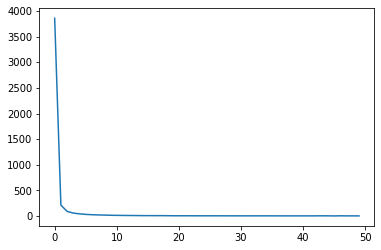

In [31]:
import matplotlib.pyplot as plt
plt.plot(graph_l1)
plt.show()

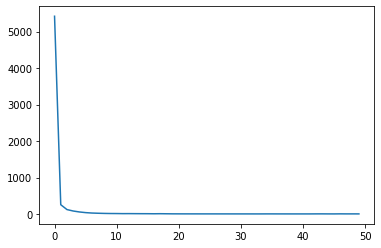

In [32]:
plt.plot(graph_l2)
plt.show()

In [35]:
import math
import matplotlib.pyplot as plt
from PIL import Image

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


img1 = reconstructed_image[2][0].cpu().detach().numpy()*255.0
img2 = data[2][0].cpu().detach().numpy()*255.0

print(img1.shape)
print(img2.shape)
print(psnr(img1,img2))

(64, 64)
(64, 64)
34.01630352316082


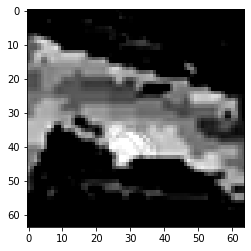

In [33]:
fplt.imshow(img1, cmap='gray', vmin=0, vmax=255)

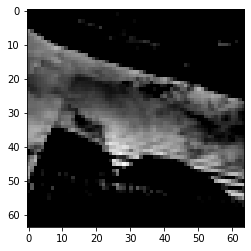

In [34]:
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)